In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

####Read in sample metadata and OTU table

In [113]:
workDir = '/home/chantal/Chazy/Chazy_SIP/data/'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqSIP = 'bulk-core'


#biomFile = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-7/OTU_binning/otu_table_wtax.biom'
#metadataFile = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-7/metadata_SIP.txt'
#treeFile = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-6/fasttree/otusn.tree'


# l2fc params
l2fc_threshold = 1
BD_min = 1.7125    # from Ashley's succ-C paper; G+C =~ 0.54
BD_max = 2

# misc
nprocs = 10

In [114]:
%%R -i physeqDir -i physeqSIP

F = file.path(physeqDir, physeqSIP)
print(F)
physeq.SIP = readRDS(F)
physeq.SIP.m = physeq.SIP %>% sample_data
physeq.SIP = prune_samples(physeq.SIP.m$Sample_Date == '9/24/14' & physeq.SIP.m$Land_Management != 'PAS',
                           physeq.SIP) %>% filter_taxa(function(x) sum(x) > 0, TRUE)

physeq.SIP

[1] "/home/chantal/Chazy/data/phyloseq//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13199 taxa and 16 samples ]
sample_data() Sample Data:       [ 16 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 13199 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 13199 tips and 13198 internal nodes ]


In [126]:
%%R
get_l2fc = function(physeq.obj) {
    physeq.md = sample_data(physeq.obj)
    dds = phyloseq_to_deseq2(physeq.obj, ~ Till)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    r = results(dds, independentFiltering = TRUE, lfcThreshold = 0, cooksCutoff = FALSE, pAdjustMethod = "BH")
    r$OTU = rownames(r)
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])
    TT = data.frame(tax_table(physeq.obj))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

In [117]:
%%R
#m = expand.grid(Day = c(1,3,7,14,30), Treatment = c("13C", "13X"))
#m = m[-c(1, 10), ]
#m

  Day Treatment
2   3       13C
3   7       13C
4  14       13C
5  30       13C
6   1       13X
7   3       13X
8   7       13X
9  14       13X


In [127]:
%%R
registerDoParallel(8)

df.l2fc = get_l2fc(physeq.SIP)
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: "OTU"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


            OTU log2FoldChange     lfcSE         padj    Rank1
1      OTU.4940  -2.6819354312 1.7632850           NA Bacteria
2      OTU.4163  -0.8231492584 1.7060963           NA Bacteria
3      OTU.5493   1.9089274430 1.5440351           NA Bacteria
4      OTU.1739   1.2044031227 1.6640375           NA Bacteria
5      OTU.1813  -0.5266578472 1.2661866 8.425789e-01 Bacteria
6     OTU.27780  -1.3588500792 1.6296158           NA Bacteria
7       OTU.778  -1.3937223650 0.4822499 5.011514e-02 Bacteria
8      OTU.5511   0.8994519640 1.1607163 6.810907e-01 Bacteria
9      OTU.6957   2.5038345985 1.7616971           NA Bacteria
10    OTU.11282   1.9315887225 1.5280823           NA Bacteria
11     OTU.5658   0.7664700468 1.4302543           NA Bacteria
12     OTU.7376   2.7095657332 1.4703976           NA Bacteria
13     OTU.5664  -0.1410552225 1.5684896           NA Bacteria
14     OTU.8169  -2.4989587662 1.6802562           NA Bacteria
15    OTU.17812   1.4864617414 1.2069851           NA B

In [128]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

    meanl2fc
1 -0.1233841


In [129]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

    sdl2fc
1 1.765126


In [130]:
%%R
df.l2fc$Till[df.l2fc$log2FoldChange < 0] = "NT"
df.l2fc$Till[df.l2fc$log2FoldChange > 0] = "PT"

In [19]:
%%R
write.table(df.l2fc, "data/l2fc_table_bulk_NTPT", row.names = FALSE, sep = ",")

In [20]:
%%R
df.l2fc = read.table('data/l2fc_table_bulk_NTPT', sep = ',', header = TRUE)

In [131]:
%%R
head(df.l2fc)

        OTU log2FoldChange    lfcSE      padj    Rank1            Rank2
1  OTU.4940     -2.6819354 1.763285        NA Bacteria  __Acidobacteria
2  OTU.4163     -0.8231493 1.706096        NA Bacteria    __Chloroflexi
3  OTU.5493      1.9089274 1.544035        NA Bacteria    __Chloroflexi
4  OTU.1739      1.2044031 1.664037        NA Bacteria __Planctomycetes
5  OTU.1813     -0.5266578 1.266187 0.8425789 Bacteria __Planctomycetes
6 OTU.27780     -1.3588501 1.629616        NA Bacteria __Planctomycetes
           Rank3                  Rank4 Rank5 Rank6 Rank7 Rank8 Till
1        __32-21 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   NT
2         __S085 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   NT
3         __S085 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   PT
4        __OM190 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   PT
5        __OM190 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   NT
6 __Pla4_lineage __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   NT


####Function arguments

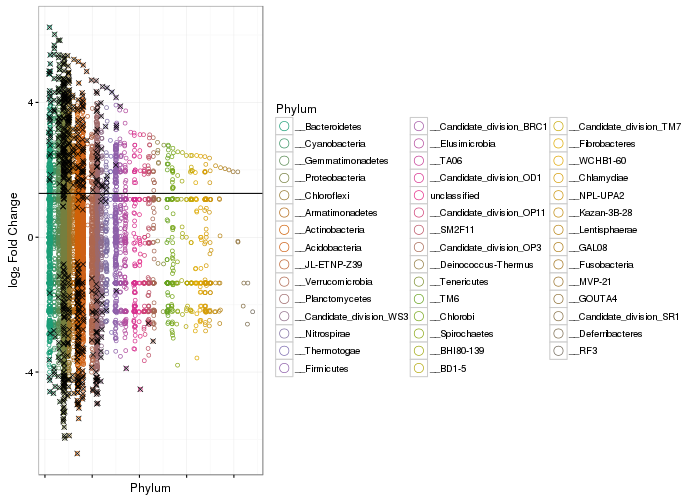

In [132]:
%%R -w 700 -h 500
d = filter(df.l2fc, !(is.na(log2FoldChange)))
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
#p = p + facet_wrap(~Substrate)#, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= 0.10), color = "black", shape = 4, size = 2)

p = p + geom_hline(yintercept = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

In [134]:
%%R
PTresp = filter(df.l2fc, padj <=0.10, log2FoldChange > 0)
length(unique(PTresp$OTU))

[1] 398


In [135]:
%%R
PTresp = filter(df.l2fc, padj <=0.10, log2FoldChange > 0)
length((PTresp$OTU))

[1] 398


In [136]:
%%R
NTresp = filter(df.l2fc, padj <=0.10, log2FoldChange < 0)
length(unique(NTresp$OTU))

[1] 307


In [137]:


%%R
NTresp = filter(df.l2fc, padj <=0.10, log2FoldChange < 0)
length((NTresp$OTU))

[1] 307


In [138]:
%%R
NT1 = filter(df.l2fc, Till == "NT", Treatment !="H2O", Day == 1, padj <= 0.10)
NT3 = filter(df.l2fc, Till == "NT",Treatment !="H2O", Day == 3, padj <= 0.10)
NT7 = filter(df.l2fc, Till == "NT", Treatment !="H2O",Day == 7, padj <= 0.10)
NT14 = filter(df.l2fc, Till == "NT", Treatment !="H2O",Day == 14, padj <= 0.10)
NT30 = filter(df.l2fc, Till == "NT",Treatment !="H2O", Day == 30, padj <= 0.10)
PT1 = filter(df.l2fc, Till == "PT", Treatment !="H2O",Day == 1, padj <= 0.10)
PT3 = filter(df.l2fc, Till == "PT", Treatment !="H2O",Day == 3, padj <= 0.10)
PT7 = filter(df.l2fc, Till == "PT", Treatment !="H2O",Day == 7, padj <= 0.10)
PT14 = filter(df.l2fc, Till == "PT",Treatment !="H2O", Day == 14, padj <= 0.10)
PT30 = filter(df.l2fc, Till == "PT", Treatment !="H2O",Day == 30, padj <= 0.10)
#length(unique(NT30$OTU))
length(unique(NT30$OTU))
#length(intersect(NT7$OTU, PT7$OTU))


Error in eval(expr, envir, enclos) : object 'Treatment' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'Treatment' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [29]:
%%R
NT1 = filter(df.l2fc, Till == "NT",Treatment !="H2O", Day == 1, padj > 0.10)
NT3 = filter(df.l2fc, Till == "NT",Treatment !="H2O", Day == 3, padj > 0.10)
NT7 = filter(df.l2fc, Till == "NT", Treatment !="H2O",Day == 7, padj > 0.10)
NT14 = filter(df.l2fc, Till == "NT",Treatment !="H2O", Day == 14, padj > 0.10)
NT30 = filter(df.l2fc, Till == "NT",Treatment !="H2O", Day == 30, padj > 0.10)
PT1 = filter(df.l2fc, Till == "PT", Treatment !="H2O",Day == 1, padj > 0.10)
PT3 = filter(df.l2fc, Till == "PT", Treatment !="H2O",Day == 3, padj > 0.10)
PT7 = filter(df.l2fc, Till == "PT", Treatment !="H2O",Day == 7, padj > 0.10)
PT14 = filter(df.l2fc, Till == "PT",Treatment !="H2O", Day == 14, padj > 0.10)
PT30 = filter(df.l2fc, Till == "PT",Treatment !="H2O", Day == 30, padj > 0.10)

NT.na.1 = filter(df.l2fc, Till == "NT",Treatment !="H2O", Day == 1, is.na(padj))
NT.na.3 = filter(df.l2fc, Till == "NT",Treatment !="H2O", Day == 3, is.na(padj))
NT.na.7 = filter(df.l2fc, Till == "NT",Treatment !="H2O", Day == 7, is.na(padj))
NT.na.14= filter(df.l2fc, Till == "NT",Treatment !="H2O", Day == 14, is.na(padj))
NT.na.30= filter(df.l2fc, Till == "NT",Treatment !="H2O", Day == 30, is.na(padj))
PT.na.1 = filter(df.l2fc, Till == "PT",Treatment !="H2O", Day == 1, is.na(padj))
PT.na.3 = filter(df.l2fc, Till == "PT",Treatment !="H2O", Day == 3, is.na(padj))
PT.na.7 = filter(df.l2fc, Till == "PT",Treatment !="H2O", Day == 7, is.na(padj))
PT.na.14= filter(df.l2fc, Till == "PT",Treatment !="H2O", Day == 14, is.na(padj))
PT.na.30= filter(df.l2fc, Till == "PT",Treatment !="H2O", Day == 30, is.na(padj))
#length(unique(NT30$OTU))
#length(unique(PT14$OTU))
#length(intersect(NT14$OTU, PT14$OTU))
length(unique(NT.na.30$OTU))
#length(unique(PT.na.30$OTU))
#length(intersect(NT.na.30$OTU, PT.na.30$OTU))


[1] 4071


In [30]:
%%R 
new_df.l2fc = df.l2fc %>% 
filter(!is.na(log2FoldChange)) %>% 
filter(!is.na(padj)) %>%
select(log2FoldChange, padj, OTU, Rank2, Rank4, Day, Treatment) 


In [31]:
%%R
head(new_df.l2fc)

  log2FoldChange      padj       OTU            Rank2                  Rank4
1      -2.089234 0.7820466  OTU.1813 __Planctomycetes __uncultured_bacterium
2      -0.340763 0.9192851   OTU.778 __Planctomycetes __uncultured_bacterium
3       2.259355 0.7820466  OTU.5511 __Planctomycetes __uncultured_bacterium
4       1.633979 0.7820466 OTU.11282 __Planctomycetes __uncultured_bacterium
5      -1.501079 0.7820466  OTU.2180 __Planctomycetes __uncultured_bacterium
6      -1.143414 0.7820466 OTU.12365 __Planctomycetes __uncultured_bacterium
  Day Treatment
1   3       13C
2   3       13C
3   3       13C
4   3       13C
5   3       13C
6   3       13C


In [32]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange < 0] = "NT enriched"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 &  new_df.l2fc$log2FoldChange > 0] = "PT enriched"

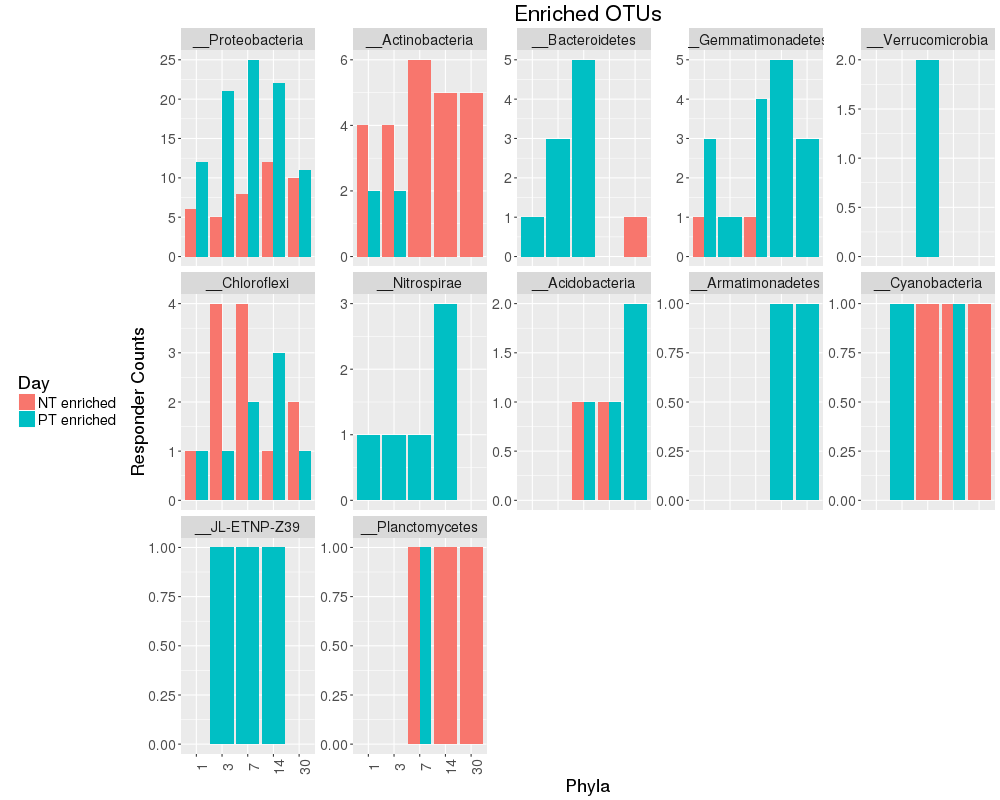

In [33]:
%%R -w 1000 -h 800
dcounts = new_df.l2fc %>%
          #filter(!is.na(log2FoldChange)) %>%
          #filter(!is.na(padj)) %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(Rank2, Day, Resp_status, Treatment) %>%
          summarize(responders = sum(padj<= 0.10))
#dcounts = filter(dcounts, Rank2 %in% c("__Proteobacteria", "__Acidobacteria", "__Bacteroidetes", "__Planctomycetes", "__Chloroflexi", "__Actinobacteria", "__Verrucomicrobia", "__Gemmatimonadetes", "__Candidate_division_WS3", "__Cyanobacteria", "__Armatimonadetes", "__Firmicutes", "__Nitrospirae", "__Chlorobi"))
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)
#newrow = c("__Firmicutes", "October", "PT enriched", as.numeric(0))
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Armatimonadetes", "October", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Armatimonadetes", "November", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Cyanobacteria", "November", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
dcounts$Rank2 <- droplevels(dcounts$Rank2)
#dcounts$responders= as.numeric(dcounts$responders)
#dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = as.factor(Day) , y = responders, fill = as.factor(Resp_status))) +
    geom_bar(stat = "identity", position="dodge") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap( ~ Rank2, ncol = 5, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Phyla") + guides(fill=guide_legend(title="Day")) +
    theme(text = element_text(size=18), axis.text.x = element_text(angle=90, vjust=1), legend.position="left") 


p

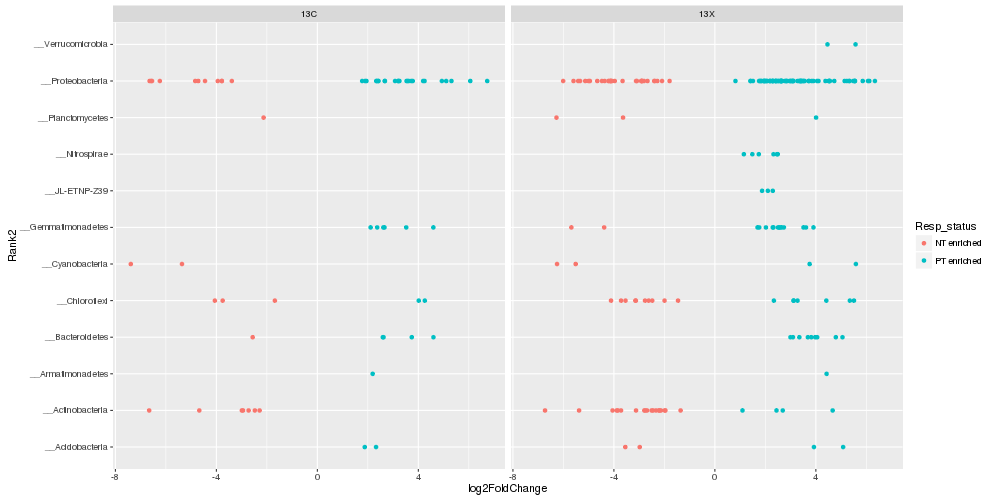

In [34]:
%%R -w 1000 -h 500
enriched = filter(new_df.l2fc, padj <=0.10)
head(enriched)

p = ggplot(enriched, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Treatment, ncol = 5)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

## Matching up with SIP Incorporators

In [139]:
%%R
SIP.inc = read.table('/home/chantal/Chazy/Chazy_SIP/data/l2fc_sparse-maxRejH.txt', sep = '\t', header = TRUE)
head(SIP.inc)

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C   3         4             NTH OTU.4163      0.2905525 0.4758928
2       13C   3         4             NTH OTU.5493     -0.2477539 0.8663980
3       13C   3         4             NTH OTU.1739     -0.3623365 0.9103254
4       13C   3         4             NTH OTU.1813      0.0000000 1.0000000
5       13C   3         4             NTH  OTU.778      0.4419146 0.3382425
6       13C   3         4             NTH OTU.5511      0.6736674 0.2322352
  padj    Rank1            Rank2          Rank3                  Rank4 Rank5
1    1 Bacteria    __Chloroflexi         __S085 __uncultured_bacterium  <NA>
2    1 Bacteria    __Chloroflexi         __S085 __uncultured_bacterium  <NA>
3    1 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
4    1 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
5    1 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
6    1

In [140]:
%%R
df.bulkSIP = plyr::rename(df.l2fc, c('log2FoldChange' = 'LFC_Till', 'padj' = 'p_Till'))
head(df.bulkSIP)

        OTU   LFC_Till    lfcSE    p_Till    Rank1            Rank2
1  OTU.4940 -2.6819354 1.763285        NA Bacteria  __Acidobacteria
2  OTU.4163 -0.8231493 1.706096        NA Bacteria    __Chloroflexi
3  OTU.5493  1.9089274 1.544035        NA Bacteria    __Chloroflexi
4  OTU.1739  1.2044031 1.664037        NA Bacteria __Planctomycetes
5  OTU.1813 -0.5266578 1.266187 0.8425789 Bacteria __Planctomycetes
6 OTU.27780 -1.3588501 1.629616        NA Bacteria __Planctomycetes
           Rank3                  Rank4 Rank5 Rank6 Rank7 Rank8 Till
1        __32-21 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   NT
2         __S085 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   NT
3         __S085 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   PT
4        __OM190 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   PT
5        __OM190 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   NT
6 __Pla4_lineage __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   NT


In [141]:
%%R
combo = left_join(SIP.inc, df.bulkSIP)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: c("OTU", "Rank1", "Rank2", "Rank3", "Rank4", "Rank5", "Rank6", "Rank7", "Rank8")

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [204]:
%%R
combo.incsig = filter(combo, padj <=0.10, p_Till <= 0.10)

In [205]:
%%R
head(combo.incsig)

  Treatment Day Replicate Land_Management       OTU log2FoldChange            p
1       13C  30         4             NTH OTU.13455       1.870800 9.253734e-04
2       13C  30         4             NTH   OTU.787       4.760010 2.572804e-08
3       13C  30         4             NTH   OTU.761       4.089055 5.282606e-10
4       13C  30         4             NTH OTU.12975       1.368123 4.416831e-03
5       13C  30         4             NTH   OTU.963       2.945506 6.303424e-13
6       13C  30         4             NTH  OTU.1141       3.269545 8.225000e-08
          padj    Rank1            Rank2              Rank3
1 2.221924e-02 Bacteria __Planctomycetes            __OM190
2 2.571326e-06 Bacteria __Planctomycetes __Planctomycetacia
3 8.202189e-08 Bacteria __Planctomycetes __Planctomycetacia
4 7.232457e-02 Bacteria __Planctomycetes __Planctomycetacia
5 1.686408e-10 Bacteria __Planctomycetes __Planctomycetacia
6 7.449623e-06 Bacteria __Planctomycetes __Planctomycetacia
                   R

In [212]:
%%R
combo.incsig %>% group_by(Treatment, Land_Management) %>% summarise(counts = n()) %>% as.data.frame 

  Treatment Land_Management counts
1       13C             NTH    160
2       13C             PTH    164
3       13X             NTH    115
4       13X             PTH    132


In [145]:
%%R
multresp = combo.incsig %>% group_by(OTU) %>% summarise(counts = n()) %>% filter(counts >1) %>% as.data.frame

In [146]:
%%R
filter(combo.incsig, OTU %in% multresp$OTU, Treatment == '13X', Till == 'PT') %>% 
    arrange(OTU, Day) %>% select(Treatment, Day, Land_Management, OTU, Till) %>% group_by(OTU, Land_Management)%>%
    summarise(counts = n()) %>% as.data.frame()

         OTU Land_Management counts
1      OTU.1             NTH      4
2      OTU.1             PTH      3
3     OTU.10             NTH      3
4     OTU.10             PTH      4
5  OTU.10126             PTH      1
6   OTU.1025             PTH      2
7   OTU.1141             PTH      2
8  OTU.12022             NTH      4
9  OTU.12022             PTH      4
10 OTU.12102             PTH      1
11 OTU.12817             NTH      1
12 OTU.12817             PTH      2
13 OTU.12975             NTH      1
14 OTU.12975             PTH      1
15  OTU.1384             NTH      1
16  OTU.1384             PTH      3
17 OTU.14002             PTH      1
18 OTU.14039             NTH      3
19 OTU.14039             PTH      2
20 OTU.16549             NTH      2
21 OTU.16549             PTH      3
22   OTU.170             NTH      1
23   OTU.170             PTH      4
24 OTU.18740             NTH      1
25 OTU.18740             PTH      1
26 OTU.18841             NTH      1
27 OTU.18841             PTH

In [149]:
%%R
head(combo)

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C   3         4             NTH OTU.4163      0.2905525 0.4758928
2       13C   3         4             NTH OTU.5493     -0.2477539 0.8663980
3       13C   3         4             NTH OTU.1739     -0.3623365 0.9103254
4       13C   3         4             NTH OTU.1813      0.0000000 1.0000000
5       13C   3         4             NTH  OTU.778      0.4419146 0.3382425
6       13C   3         4             NTH OTU.5511      0.6736674 0.2322352
  padj    Rank1            Rank2          Rank3                  Rank4 Rank5
1    1 Bacteria    __Chloroflexi         __S085 __uncultured_bacterium  <NA>
2    1 Bacteria    __Chloroflexi         __S085 __uncultured_bacterium  <NA>
3    1 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
4    1 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
5    1 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
6    1

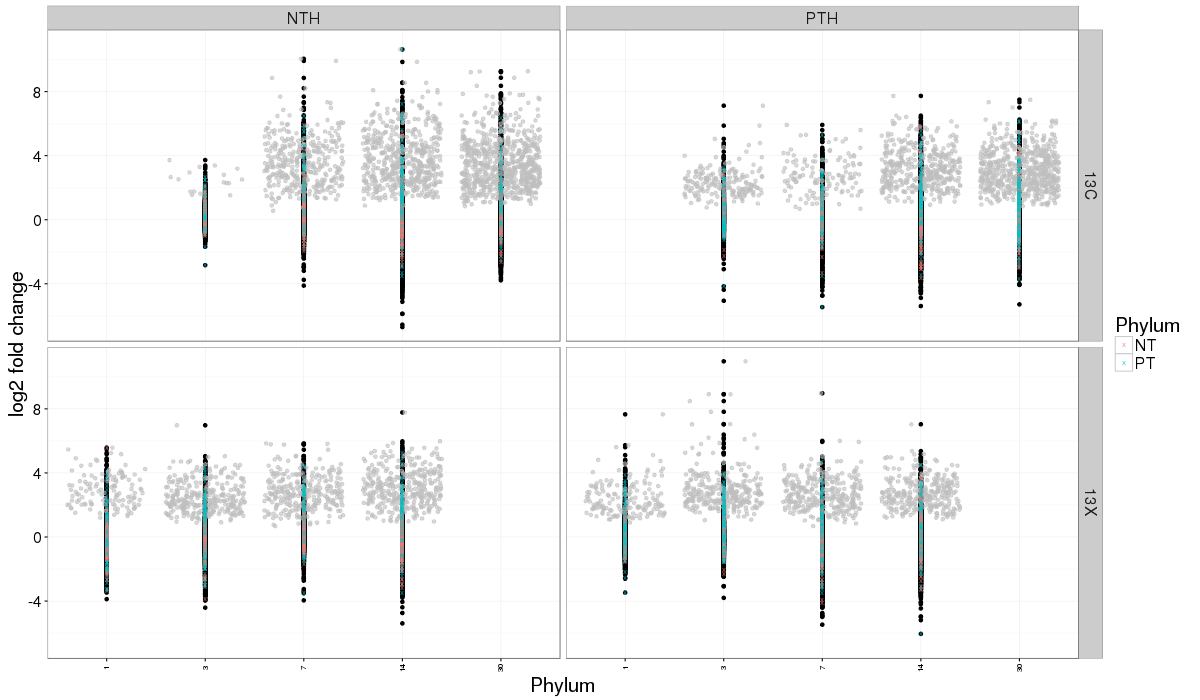

In [169]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.f = combo %>%
    mutate(Rank2 = Rank2 %>% as.character)

df.l2fc.f.f = df.l2fc.f.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))
#df.l2fc.f.f$Phyl = reorder(df.l2fc.f.f$Rank2, -df.l2fc.f.f$log2FoldChange)


df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))


df.l2fc.f.f.sigBulk = df.l2fc.f.f %>%
    filter(p_Till <= padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.f = arrange(df.l2fc.f.f, Rank2)


p.l2fc.x = ggplot(df.l2fc.f.f, aes(as.factor(Day))) +
    geom_point(aes(y=log2FoldChange)) +
    geom_jitter(data = df.l2fc.f.f.sig, aes(y = log2FoldChange), color = 'grey', alpha = 0.6)+
    geom_point(data=df.l2fc.f.f.sigBulk, aes(y=log2FoldChange, color = Till), shape='x', alpha=0.8, size=2.5) +
    facet_grid(Treatment~Land_Management) +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=20), axis.text.x  = element_text(angle=90, vjust=0.4, size=8)) + #+
    scale_color_discrete(name = 'Phylum') 
    guides(col = guide_legend(nrow = 6))

p.l2fc.x

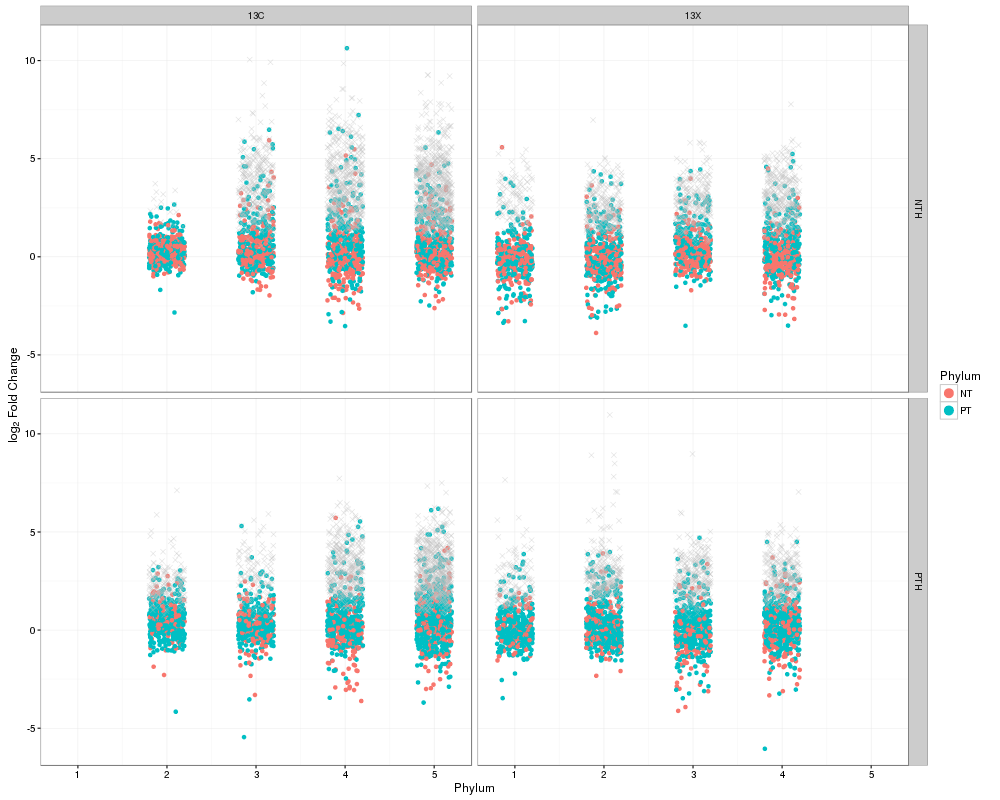

In [196]:
%%R -w 1000 -h 800
d = filter(combo, !(is.na(log2FoldChange)))
FDR = 0.10

d$Day = factor(d$Day)

M = max(as.numeric(d$Day), na.rm = TRUE) + 1
d$x = as.numeric(d$Day)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange))
#p = p + facet_wrap(~Substrate)#, nrow=1, ncol=4)

#p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5, color = 'black')

#p = p + scale_color_manual(values = getPalette(colourCount))


p = p + geom_point(data = subset(d, p_Till <=0.10), aes(color = Till))

p = p + geom_point(data = subset(d, padj <= 0.10 ), color = "grey", shape = 4, size = 2, alpha = 0.4)


p = p + theme_bw()

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p = p + facet_grid(Land_Management ~ Treatment)

p

In [203]:
%%R
combo %>% filter(padj <=0.10, p_Till <=0) %>% group_by(Treatment, Land_Management) %>% summarise(counts = n())

Source: local data frame [0 x 3]
Groups: Treatment [?]

Variables not shown: Treatment (fctr), Land_Management (fctr), counts (int)


In [199]:
%%R
head(combo)

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C   3         4             NTH OTU.4163      0.2905525 0.4758928
2       13C   3         4             NTH OTU.5493     -0.2477539 0.8663980
3       13C   3         4             NTH OTU.1739     -0.3623365 0.9103254
4       13C   3         4             NTH OTU.1813      0.0000000 1.0000000
5       13C   3         4             NTH  OTU.778      0.4419146 0.3382425
6       13C   3         4             NTH OTU.5511      0.6736674 0.2322352
  padj    Rank1            Rank2          Rank3                  Rank4 Rank5
1    1 Bacteria    __Chloroflexi         __S085 __uncultured_bacterium  <NA>
2    1 Bacteria    __Chloroflexi         __S085 __uncultured_bacterium  <NA>
3    1 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
4    1 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
5    1 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
6    1

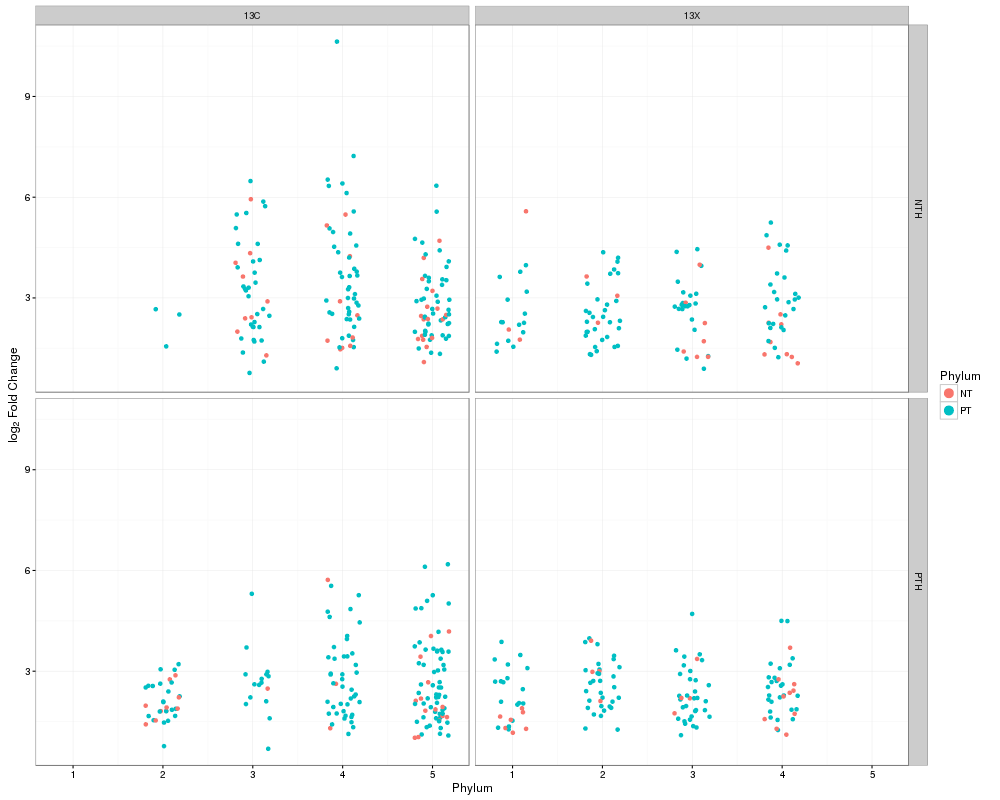

In [193]:
%%R -w 1000 -h 800
d = filter(combo, !(is.na(log2FoldChange)))
FDR = 0.10

d$Day = factor(d$Day)

M = max(as.numeric(d$Day), na.rm = TRUE) + 1
d$x = as.numeric(d$Day)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange))
#p = p + facet_wrap(~Substrate)#, nrow=1, ncol=4)

#p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5, color = 'black')

#p = p + scale_color_manual(values = getPalette(colourCount))


p = p + geom_point(data = subset(d, p_Till <=0.10 & padj <= 0.10), aes(color = Till))

p = p + theme_bw()

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p = p + facet_grid(Land_Management ~ Treatment)

p

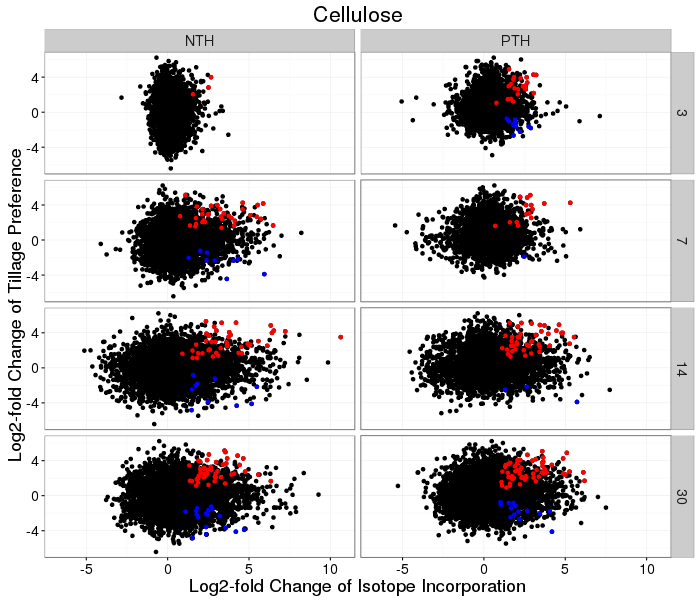

In [147]:
%%R -w 700 -h 600
combo.cell = filter(combo, Treatment == '13C')
ggplot(combo.cell, aes(log2FoldChange, LFC_Till)) + geom_point() + facet_grid(Day ~ Land_Management) +
    theme_bw() +
    theme(text = element_text(size=18)) + 
    geom_point(data = subset(combo.cell, padj <=0.10 & p_Till <=0.10 & LFC_Till > 0 ), color = 'red') + 
    geom_point(data = subset(combo.cell, padj <=0.10 & p_Till <=0.10 & LFC_Till < 0 ), color = 'blue') + 
    xlab('Log2-fold Change of Isotope Incorporation') + ylab('Log2-fold Change of Tillage Preference') + 
    ggtitle('Cellulose')

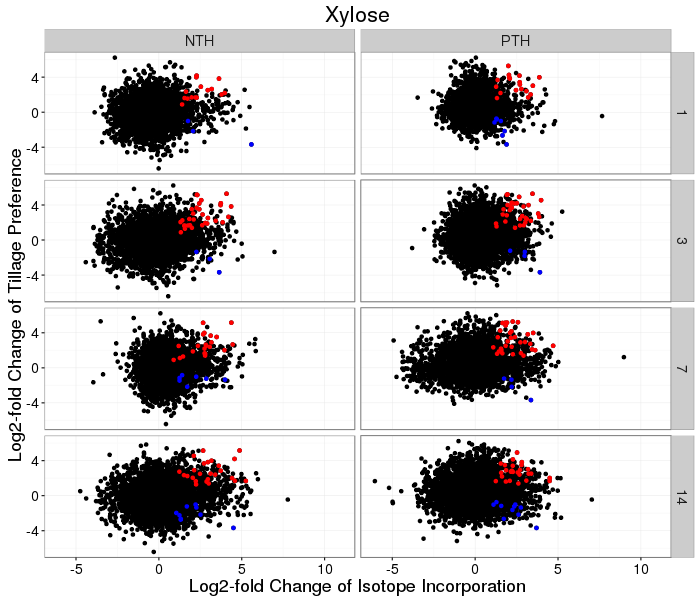

In [148]:
%%R -w 700 -h 600
combo.cell = filter(combo, Treatment == '13X')
ggplot(combo.cell, aes(log2FoldChange, LFC_Till)) + geom_point() + facet_grid(Day ~ Land_Management) +
    theme_bw() +
    theme(text = element_text(size=18)) + 
    geom_point(data = subset(combo.cell, padj <=0.10 & p_Till <=0.10 & LFC_Till > 0 ), color = 'red') + 
    geom_point(data = subset(combo.cell, padj <=0.10 & p_Till <=0.10 & LFC_Till < 0 ), color = 'blue') + 
    xlab('Log2-fold Change of Isotope Incorporation') + ylab('Log2-fold Change of Tillage Preference') +
    ggtitle('Xylose')

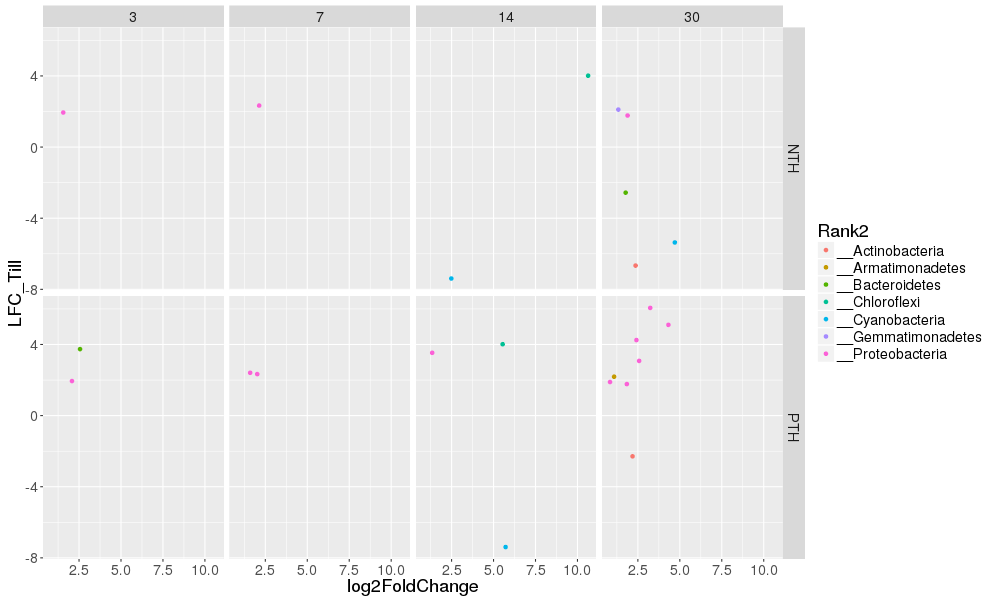

In [52]:
%%R -w 1000 -h 600
combo.cell = filter(combo.incsig, Treatment == '13C')
ggplot(combo.cell, aes(log2FoldChange, LFC_Till, color = Rank2)) + geom_point() + facet_grid(Land_Management ~ Day) +
    theme(text = element_text(size=18)) 

In [42]:
%%R
combo.cell %>% group_by(Day, Land_Management, Till) %>% summarise(counts = n())

Source: local data frame [12 x 4]
Groups: Day, Land_Management [?]

     Day Land_Management   Till counts
   (int)          (fctr) (fctr)  (int)
1      3             NTH     PT      1
2      3             PTH     PT      2
3      7             NTH     PT      1
4      7             PTH     PT      2
5     14             NTH     NT      1
6     14             NTH     PT      1
7     14             PTH     NT      1
8     14             PTH     PT      2
9     30             NTH     NT      3
10    30             NTH     PT      2
11    30             PTH     NT      1
12    30             PTH     PT      7


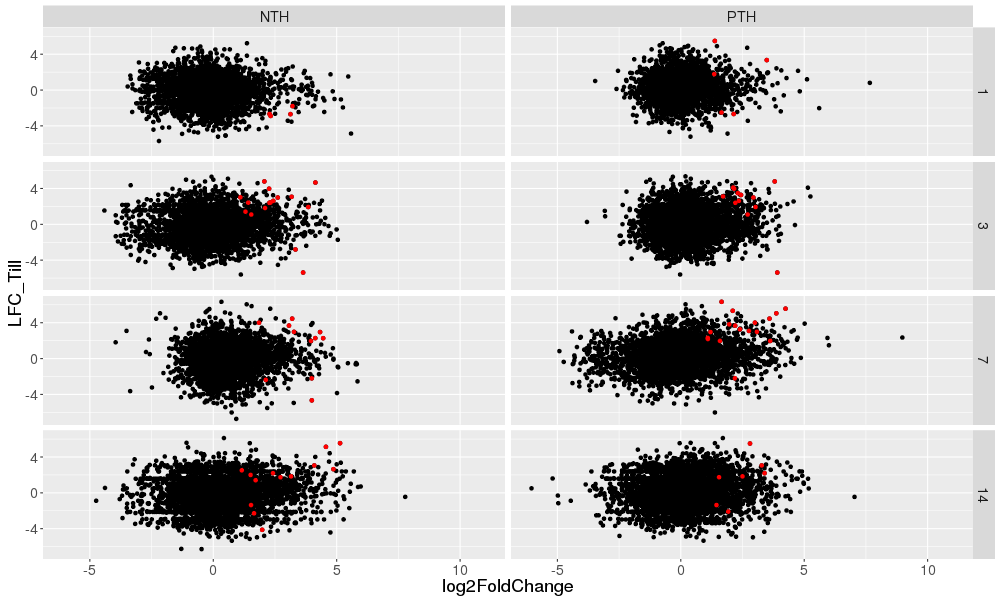

In [56]:
%%R -w 1000 -h 600
combo.xyl = filter(combo, Treatment == '13X')
ggplot(combo.xyl, aes(log2FoldChange, LFC_Till)) + geom_point() + facet_grid(Day ~ Land_Management) +
    theme(text = element_text(size=18)) + 
    geom_point(data = subset(combo.xyl, padj <=0.10 & p_Till <=0.10), color = 'red')

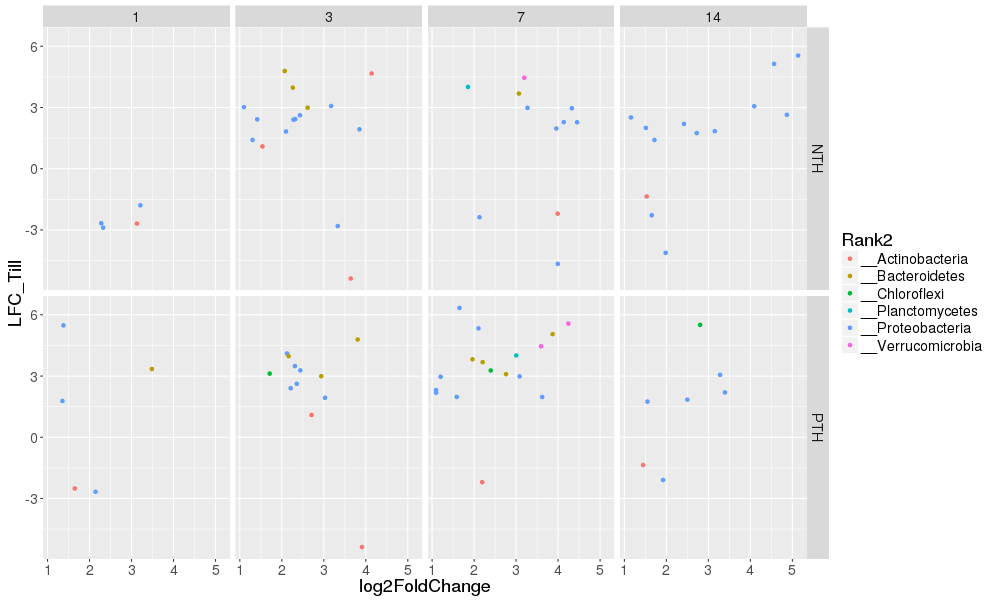

In [43]:
%%R -w 1000 -h 600
combo.xyl = filter(combo.incsig, Treatment == '13X')
ggplot(combo.xyl, aes(log2FoldChange, LFC_Till, color = Rank2)) + geom_point() + facet_grid(Land_Management ~ Day) +
    theme(text = element_text(size=18))

In [44]:
%%R
combo.xyl %>% group_by(Day, Land_Management, Till) %>% summarise(counts = n())

Source: local data frame [15 x 4]
Groups: Day, Land_Management [?]

     Day Land_Management   Till counts
   (int)          (fctr) (fctr)  (int)
1      1             NTH     NT      4
2      1             PTH     NT      2
3      1             PTH     PT      3
4      3             NTH     NT      2
5      3             NTH     PT     14
6      3             PTH     NT      1
7      3             PTH     PT     11
8      7             NTH     NT      3
9      7             NTH     PT      8
10     7             PTH     NT      1
11     7             PTH     PT     16
12    14             NTH     NT      3
13    14             NTH     PT     10
14    14             PTH     NT      2
15    14             PTH     PT      5
